# Miniproject 2: Melody generation

## Introduction

### Description

To develop a model employing ANN on real-world data requires going through several major steps, each of which with important design choices that directly impact the end results. In this project, we guide you through these choices starting from a large database of [Irish folk melodies](https://github.com/IraKorshunova/folk-rnn/tree/master/data) to your own model of symbolic music composition. 


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. Please ensure that your notebook is fully executed before handing it in. 

## Functions and imports

For your convenience we import some libraries and provide some functions below. Some libraries (`midi` and `music21==5.1.0`) should be added. If you work with the docker image, pull it `docker pull zifeo/artificial-neural-networks:cpu` before to get the latest version where these libraries are added and stop/relaunch the container (as stated in the instructions https://github.com/zifeo/artificial-neural-networks). If you work locally, be sure to import them. If you do not find the midi library for python3, install it with `python setup.py install` inside the `python3-midi` folder after cloning https://github.com/louisabraham/python3-midi.git.

Finally, fill in your sciper number(s) for the random seed and simply run the following cell.

In [1]:
# Run with 0 values. Corresponding Scipers on the left
sciper = {'student_1': 0, #212699
          'student_2': 0} #292405
seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

import midi
import music21

Using TensorFlow backend.


In [330]:
def plotMelody(P, T, dictionaries, PrP=None, PrT=None, H=None):
    """
    P: The pitch array (integer representation) or matrix (one-hot encoding)
    T: The duration array (integer representation) or matrix (one-hot encoding)
    dictionaries: The dictionaries relating integer to a pitch or duration
    PrP: (Optional) If provided with PrT, plot the transition probabilities
    PrT: (Optional) If provided with PrP, plot the transition probabilities
    H: (Optional) Add a plot with the hidden state dynamic sorted by frequency
    """
    P = np.asarray(P)
    T = np.asarray(T)
    if len(P.shape) == 1:#if array
        P = np_utils.to_categorical(P, len(dictionaries['P']))
    if len(T.shape) == 1:#if array
        T = np_utils.to_categorical(T, len(dictionaries['T']))
    
    xlim = [-1,np.where(P==1)[0][-1]+1]
    
    activeidxes = np.where(np.sum(P, axis=0)>0.)[0]
    plt.figure(figsize=(8,4))
    if PrP is not None:
        targets = np.where(P[:,activeidxes]==1)
        plt.imshow(PrP[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.') 
    else:
        plt.imshow(P[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$P[n]$")
    plt.xlim(xlim)
    plt.show()
    
    activeidxes = np.where(np.sum(T, axis=0)>0.)[0]
    plt.figure(figsize=(8,4))
    if PrT is not None:
        targets = np.where(T[:,activeidxes]==1)
        plt.imshow(PrT[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.')
    else:
        plt.imshow(T[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$T[n]$")
    plt.xlim(xlim)
    plt.show()
    
    
    if H is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H[:xlim[1]-1,k], H[1:xlim[1],k])] for k in range(H.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H = H[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$H[n]$")
        plt.show()


def plotLearningCurves(History):
    
    log = History.history
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_loss'], '--', c=c[0], label='Pitch train loss')
    plt.plot(log['val_YP_loss'], c=c[0], label='Pitch val loss')
    
    plt.plot(log['YT_loss'], '--', c=c[1], label='Dur train loss')
    plt.plot(log['val_YT_loss'], c=c[1], label='Dur val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_acc'], '--', c=c[0], label='Pitch train acc')
    plt.plot(log['val_YP_acc'], c=c[0], label='Pitch val acc')
    
    plt.plot(log['YT_acc'], '--', c=c[1], label='Dur train acc')
    plt.plot(log['val_YT_acc'], c=c[1], label='Dur val acc')
    plt.legend(loc='best')

def sample(preds, temperature=1.):
    """Helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def writeMIDI(xP, xT, dictionaries, label):

    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern(format = 0, resolution=480)
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    pattern.append(track)
    Events = []
    
    pseq = [dictionaries['P'][p] for p in xP]
    tseq = [dictionaries['T'][t] for t in xT]
    for t, p in zip(tseq, pseq):
        e = midi.NoteOnEvent(tick=0, velocity=90, pitch=p)
        track.append(e)
        e = midi.NoteOffEvent(tick=t, velocity=0, pitch=p)
        track.append(e)
        
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    # Save the pattern to disk
    midi.write_midifile(label, pattern)

## Exercise 1 : Data processing
### Description

For a real world application of ANNs, the original data should be translated into a representation understandable by an ANN. This step is often neglected but is of outmost importance. In order for you to better understand how ANN are applied to real world problems, the first step of this miniproject will guide you through a possible representation. 

Note that in general, your representation should be normalized in order to obtain homogeneous data from which a structure can be extracted by your ANN model. Importantly, all processing steps toward your representation should not (or minimally) distort your original data.

To represent MIDI files, we provide you with a Python MIDI library. You should then

0. Download the MIDI tar file from [this link](https://github.com/IraKorshunova/folk-rnn/tree/master/data) and put it in a folder named "chorpus" at the same level of this notebook.
1. Parse the chorpus to extract the label of (a random subset of) the data (code is provided)
2. Read each MIDI file in the subset with the midi [library](https://github.com/louisabraham/python3-midi)
3. For each data sequence extract the sequence of MIDI notes defined by two dimensions ("P": the sequence of note pitches (integer between 0 and 127 representing a piano key), "T": the sequence of note durations.
4. Select two melodies and display them both as sequences of MIDI events and sequence of notes in two dimensions. Control that your representation is correct.

For step 3, you should learn how MIDI files are constructed. Below, we give a minimal explanation and some code for this particular project. For a more complete explanation, look for MIDI in your favorite search engine. Given this dataset, you can observe that it is monophonic (one note at a time) and there's a small delay (1 tick) inbetween each note. You could decide to ignore this delay or correct (recommanded) for it.

A MIDI files is composed of timed events of many kinds. For this project, we focus on the events related to notes being played or stopped. Those are MIDI events "Note Off" and "Note On". Each event is timed with respect with the previous one (dt). The duration of a note is therefore given by the cummulated dt inbetween the event associated to a note's onset and the event associated with the same note's offset.
        

### Minimal code to read MIDI files

In [3]:
def display(midi_file="chorpus/sessiontune0.mid"):
    #index 0 for first track only
    events = midi.read_midifile(midi_file)[0] 
    tick = 0
    print(midi_file)
    print("#"*40)
    print("tick \t pitch \t message \t velocity")
    print("#"*40+'\n')
    for n, event in enumerate(events):
        tick += event.tick
        if event.name in ['Note On', 'Note Off']:
            if n<13 or n>len(events)-10:
                print("%i \t %i \t %s \t %i"%(tick, event.data[0], event.name, event.data[1]))
            if n in range(20,23):
                print(". \t . \t . \t \t .")
    print("#"*40+'\n')

display()

datapath = "chorpus/"
dataset = {}
np.random.seed(seed)

for filename in os.listdir(datapath):
    if filename.endswith("mid"):
        label = filename[:-4]
        #Down sample dataset
        if np.random.rand() < 0.1:
            dataset[label] = {"T":[], "P": []}
print("%i/%i melodies retained"%(len(list(dataset.keys())), len(os.listdir(datapath))))

chorpus/sessiontune0.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 67 	 Note On 	 105
240 	 67 	 Note Off 	 0
241 	 64 	 Note On 	 80
480 	 64 	 Note Off 	 0
481 	 64 	 Note On 	 80
720 	 64 	 Note Off 	 0
721 	 64 	 Note On 	 95
1200 	 64 	 Note Off 	 0
1201 	 62 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
33601 	 67 	 Note On 	 80
33840 	 67 	 Note Off 	 0
33841 	 69 	 Note On 	 95
34080 	 69 	 Note Off 	 0
34081 	 71 	 Note On 	 80
34320 	 71 	 Note Off 	 0
34321 	 72 	 Note On 	 80
34560 	 72 	 Note Off 	 0
########################################

4720/45854 melodies retained


### Solution

In [4]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm 
from IPython.core.debugger import set_trace


def parseMIDI(midi_file):
    events = midi.read_midifile(midi_file)[0] #index 0 for first track only  
    T = []
    P = []
    tick = 0
    for n, event in (enumerate(events)):
        if event.name=='End of Track':
            break
        if event.name=="Note On":
            next_event=events[n+1]
            pitch=event.data[0]
            dT=next_event.tick
            if next_event.name!='Note Off':
                return None,n
            P.append(pitch)
            T.append(dT)
    return P, T

polymorphic_files=[]
for label in tqdm(list(dataset.keys())):
    Pseq, Tseq = parseMIDI(datapath+label+".mid")
    if Pseq is None:
        polymorphic_files.append((label,Tseq))
        continue
    dataset[label]['T']= Tseq
    dataset[label]['P']= Pseq
    

for label in (np.random.choice(list(dataset.keys()), 2)):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('/n')


HBox(children=(IntProgress(value=0, max=4720), HTML(value='')))


sessiontune35812
MIDI events
chorpus/sessiontune35812.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 51 	 Note On 	 105
480 	 51 	 Note Off 	 0
481 	 51 	 Note On 	 80
960 	 51 	 Note Off 	 0
961 	 58 	 Note On 	 95
1200 	 58 	 Note Off 	 0
1201 	 51 	 Note On 	 80
1440 	 51 	 Note Off 	 0
1441 	 53 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
29521 	 53 	 Note On 	 80
29760 	 53 	 Note Off 	 0
29761 	 51 	 Note On 	 95
30240 	 51 	 Note Off 	 0
30241 	 49 	 Note On 	 80
30480 	 49 	 Note Off 	 0
30481 	 53 	 Note On 	 80
30720 	 53 	 Note Off 	 0
########################################

Note representation
{'T': [479, 479, 239, 239, 239, 239, 239, 239, 239, 239, 159, 319, 239, 239, 479, 479, 239, 239, 239, 239, 239, 239, 159, 159, 159, 479, 239, 239, 479, 479, 239, 239, 239, 239, 239, 239, 239, 239, 159, 319, 239, 239, 479, 479, 239, 239, 239, 239, 239, 239, 159, 159, 159, 479, 239, 239, 

## Exercise 2: Tokenzation and translation to integer
### Description

Now you should have a "dataset" dictionary where each entry corresponds to one melody example from a subset of the full dataset. In turn, every melody example is represented by a dictionary with two sequences: the "P" entry being the sequence of pitches and the "T" entry, the sequence of durations. Here, you will implement the first steps to translate this dataset in a language that can be read by your ANN models. To achieve that, we will later use the [one-hot encoding scheme](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), which will associate each input (and output) unit of your network to a unique pitch or duration. In your network, these units will then be sequentially activated in the same order as their corresponding pitch/duration in your dataset. And at each note, the model will be trained to approximate the probability distributions of the upcoming pitch and duration.

1. Gather in a list of all possible pitches and durations in your dataset. These two lists will be your "dictionaries" translating a pitch/duration to a unique integer between 0 and the number of entries (-1) in the pitch/duration dictionary.
2. Translate the pitch/duration sequence of each melody to the integer representation.
3. Select randomly two melodies and display them in the note representation and translated to integer. Check that the translation is correct.

### Solution

In [6]:
all_possible_pitches=list(set([pitch for key in dataset for pitch in dataset[key]["P"]]))
all_possible_durations=list(set([duration for key in dataset 
                                 for duration in dataset[key]["T"]]))
dataset_token_trans={label:{"P":[all_possible_pitches.index(pitch) for pitch in data["P"]] ,
                            "T":[all_possible_durations.index(dur) for dur in data["T"]]}
                     for label,data in dataset.items()
                    }

In [7]:
for label in (np.random.choice(list(dataset.keys()), 2)):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print("Token representation")
    print(dataset_token_trans[label])
    print('/n')

sessiontune21200
MIDI events
chorpus/sessiontune21200.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 60 	 Note On 	 105
480 	 60 	 Note Off 	 0
481 	 55 	 Note On 	 80
720 	 55 	 Note Off 	 0
721 	 60 	 Note On 	 80
960 	 60 	 Note Off 	 0
961 	 57 	 Note On 	 95
1200 	 57 	 Note Off 	 0
1201 	 60 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
29281 	 64 	 Note On 	 80
29760 	 64 	 Note Off 	 0
29761 	 65 	 Note On 	 95
30240 	 65 	 Note Off 	 0
30241 	 64 	 Note On 	 80
30480 	 64 	 Note Off 	 0
30481 	 62 	 Note On 	 80
30720 	 62 	 Note Off 	 0
########################################

Note representation
{'T': [479, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 479, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 479, 479, 239, 239, 479, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 479, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 479

## Exercise 3: Data preprocessing
### Description

Before moving to the implementation of your RNN generative model of note transition, you will perform data exploration and modification. This step will allow your model to get the most out of your original data as well as ensuring some features such as transposition invariance. 

To further improve your model, you might want to reconsider your original data. Many different approaches can be undertaken. Here you are asked to implement the a rare event suppression method and transposition invariance.

**Rare event suppression** If a unit in your network is associated to a duration that happens very rarely in your data, a possible simplification consists in removing the melodies conaining these rare events from your dataset. 
1. Plot and comment the histogram of durations in your entire dataset. Use the labels from the original duration values (rather than the integer representation). 
2. Based on your observations, remove from your dataset melodies containing very rare durations. Adjust the rejection threshold such that at most 5% of the melodies are dicarded with this step. 
3. Recompute the duration dictionary based on your filtered dataset and plot the new histogram of durations. 

**Transposition invariance** A melody is perceived similarly by the human ear if it's shifted up or down by a constant offset (see [transposition](https://en.wikipedia.org/wiki/Transposition_(music))). Here, you will force your model to be transposition invariant. For this you can choose to use one of two orthogonal methods. The first consists in transposing every melody into a common tonality (C Major/A minor). On the other hand, the second consists in transposing each melody in all possible keys. The second method will increase your dataset size by a factor bigger than 11! As the training time is directly related with the dataset size, to save computing time, we recomand that you implement the first option.

***Pitch normalization*** 
1. Use the provided function to create a new dataset where all melodies are transposed to C Major/A minor. 
2. Plot the histograms of the pitches before and after transposition.

Finally, you shoud recompute the tokenization step for your brand new filtered and normalized dataset.

### Solution

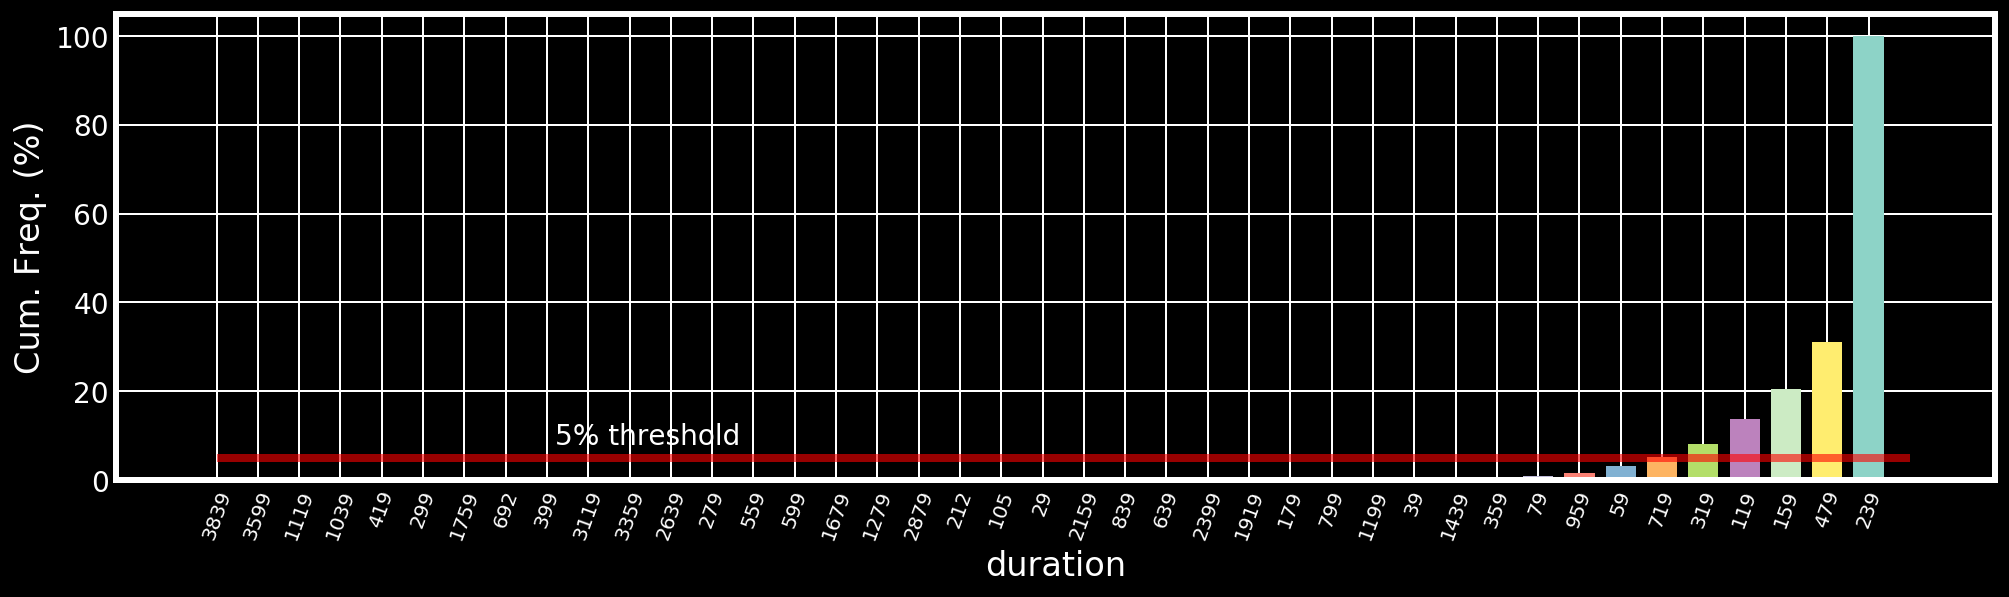

In [84]:
# Cumulative Histogram of durations
import matplotlib.pyplot as plt
import numpy as np
import operator
from collections import Counter
import pandas as pd

dataset_df=pd.DataFrame([(pitch,duration) 
                         for val in dataset.values() for duration,pitch in zip(val["T"],val["P"])],
                       columns=["pitch","duration"])

data_duration = dict(sorted(Counter([dur for dur in dataset_df.duration]).items(),
                            key=operator.itemgetter(1)))

cum_freq=[]
durs=list(data_duration.keys())
nb_durs=dataset_df.shape[0]+0.0
with plt.style.context('dark_background'):
    dim = len(data_duration)
    w = 30
    dimw = w / dim
    fig, ax = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(15)

    x = np.arange(len(data_duration))
    for i,dur in enumerate(data_duration):
        y = 100*np.sum([data_duration[d] for d in durs[:(i+1)]])/nb_durs
        cum_freq.append(y)
        b = ax.bar(x[i], y, dimw, bottom=0.001)
    ax.hlines(5,0,len(x),alpha=0.6,lw=4,color="red")
    ax.text(0.2*len(x),8,"5% threshold")
    ax.set_xticks(x)
    ax.set_xticklabels(data_duration.keys(),rotation=70,fontsize=10)
    #ax.set_yscale('log')
    ax.set_xlabel('duration')
    ax.set_ylabel('Cum. Freq. (%)')

    plt.show()

In [92]:
#Rare event supression
durs_to_keep=durs[np.min(np.where(np.array(cum_freq)>=5)):]
durs_to_remove=(set(durs)-set(durs_to_keep))
dataset_freq_thresh={label:data for label,data in dataset.items() 
                     if len(set(data["T"]).intersection(durs_to_remove))==0}

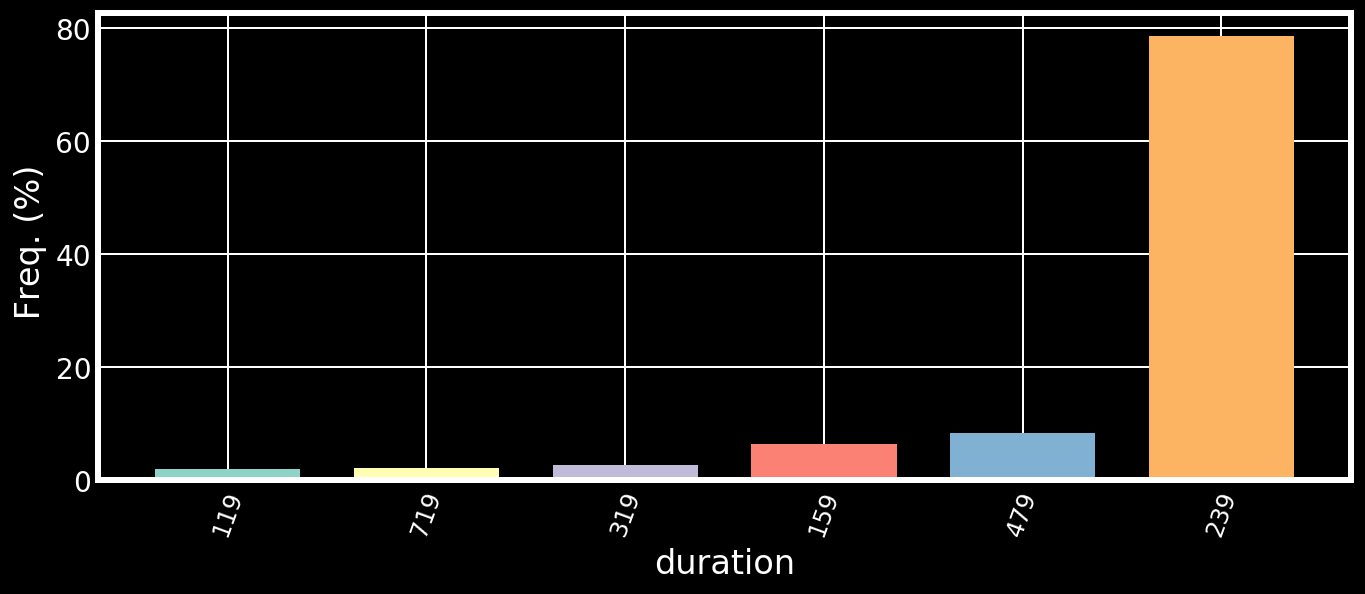

In [101]:
#  Histogram of treated durations (Rare event supression)

import matplotlib.pyplot as plt
import numpy as np
import operator
from collections import Counter
import pandas as pd

dataset_df_thresh=pd.DataFrame([(pitch,duration) 
                         for val in dataset_freq_thresh.values() for duration,pitch in zip(val["T"],val["P"])],
                       columns=["pitch","duration"])

data_duration_tresh = dict(sorted(Counter([dur for dur in dataset_df_thresh.duration]).items(),
                            key=operator.itemgetter(1)))

durs=list(data_duration_tresh.keys())
nb_durs=dataset_df_thresh.shape[0]+0.0
with plt.style.context('dark_background'):
    dim = len(data_duration)
    w = 30
    dimw = w / dim
    fig, ax = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(10)

    x = np.arange(len(data_duration_tresh))
    for i,dur in enumerate(data_duration_tresh):
        y = 100*(data_duration_tresh[dur]/nb_durs)
        b = ax.bar(x[i], y, dimw, bottom=0.001)
    ax.set_xticks(x)
    ax.set_xticklabels(data_duration_tresh.keys(),rotation=70,fontsize=12)
    #ax.set_yscale('log')
    ax.set_xlabel('duration')
    ax.set_ylabel(' Freq. (%)')

    plt.show()

In [100]:
# Transposition Invariance: Pitch Normalization

def transposeDataset(dataset):
    transposed_dataset = {}
    for label in tqdm(list(dataset.keys())):
        transposed_dataset[label] = {}
        score = music21.converter.parse(datapath+label+".mid")
        key = score.analyze('key')
        if key.mode == "major":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('C'))
        elif key.mode == "minor":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('A'))
        i = i.semitones
        transposed_dataset[label]['P'] = [p+i for p in dataset[label]['P']]
        transposed_dataset[label]['T'] = dataset[label]['T']
        
    return transposed_dataset

treated_dataset=transposeDataset(dataset_freq_thresh)

HBox(children=(IntProgress(value=0, max=3266), HTML(value='')))

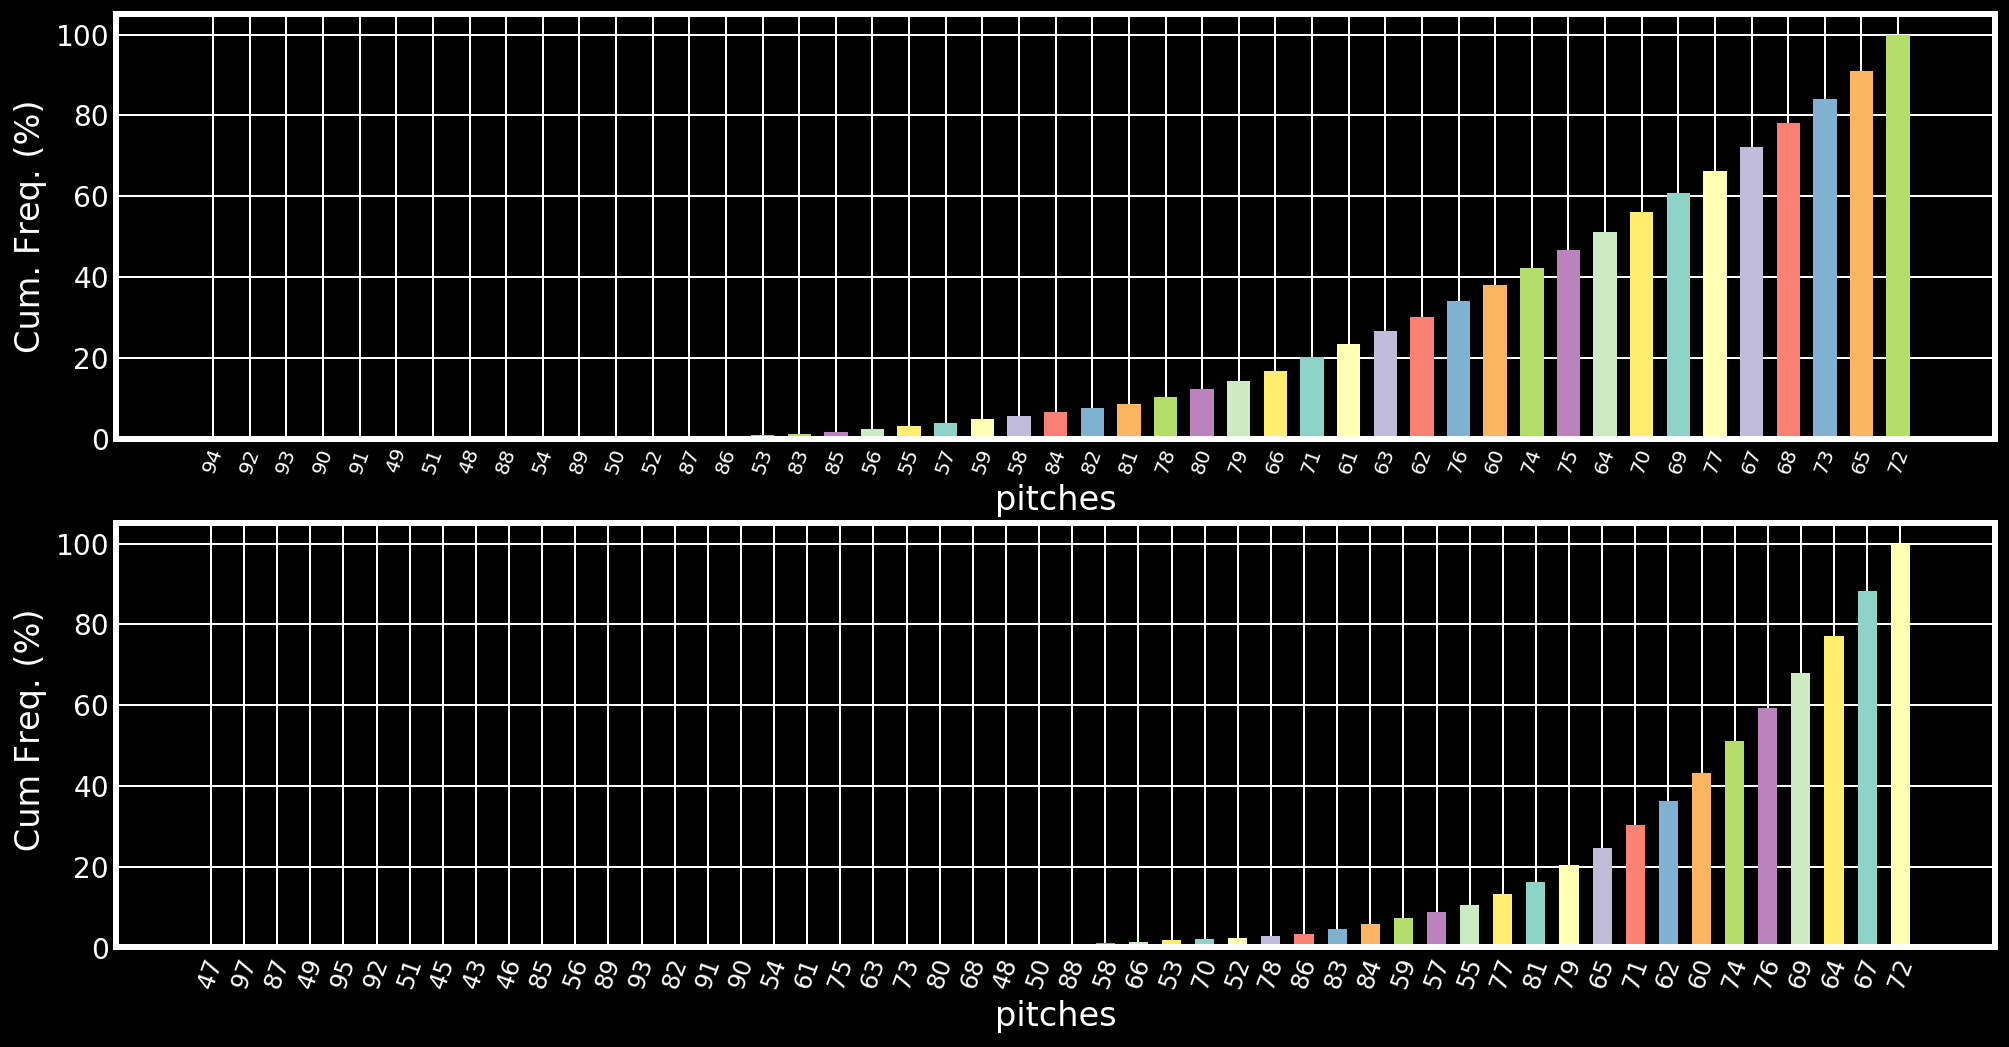

In [544]:

import matplotlib.pyplot as plt
import numpy as np
import operator
from collections import Counter
import pandas as pd

# Cumulative Histogram of pitches
dataset_df=pd.DataFrame([(pitch,duration) 
                         for val in dataset.values() for duration,pitch in zip(val["T"],val["P"])],
                       columns=["pitch","duration"])
data_pitch = dict(sorted(Counter([dur for dur in dataset_df.pitch]).items(),key=operator.itemgetter(1)))
cum_freq=[]
pitches=list(data_pitch.keys())
nb_pitches=dataset_df.shape[0]+0.0

# Histogram of treated pitches
dataset_df_treated=pd.DataFrame([(pitch,duration) 
                         for val in treated_dataset.values() for duration,pitch in zip(val["T"],val["P"])],
                       columns=["pitch","duration"])

data_pitch_treated = dict(sorted(Counter([pitch for pitch in dataset_df_treated.pitch]).items(),
                            key=operator.itemgetter(1)))

pitches_treated=list(data_pitch_treated.keys())
nb_pitches_treated=dataset_df_treated.shape[0]+0.0

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(2,1)
    fig.set_figheight(8)
    fig.set_figwidth(15)
    dim = len(data_pitch)
    w = 30
    dimw = w / dim
    x = np.arange(len(data_pitch))
    for i,dur in enumerate(data_pitch):
        y = 100*np.sum([data_pitch[d] for d in pitches[:(i+1)]])/nb_pitches
        cum_freq.append(y)
        b = ax[0].bar(x[i], y, dimw, bottom=0.001)
    #ax[0].hlines(5,0,len(x),alpha=0.6,lw=4,color="red")
    #ax[0].text(0.2*len(x),8,"5% threshold")
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(data_pitch.keys(),rotation=70,fontsize=10)
    #ax.set_yscale('log')
    ax[0].set_xlabel('pitches')
    ax[0].set_ylabel('Cum. Freq. (%)')
    dim = len(data_pitch_treated)
    #
    w = 30
    dimw = w / dim
    x = np.arange(len(data_pitch_treated))
    for i,pitch in enumerate(data_pitch_treated):
        y = 100*np.sum([data_pitch_treated[d] for d in pitches_treated[:(i+1)]])/nb_pitches_treated
        b = ax[1].bar(x[i], y, dimw, bottom=0.001)
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(data_pitch_treated.keys(),rotation=70,fontsize=12)
    #ax.set_yscale('log')
    ax[1].set_xlabel('pitches')
    ax[1].set_ylabel(' Cum Freq. (%)')

plt.show()

In [116]:
# Tokenization
all_possible_pitches_final=list(set([pitch for key in treated_dataset for pitch in treated_dataset[key]["P"]]))
all_possible_durations_final=list(set([duration for key in treated_dataset 
                                 for duration in treated_dataset[key]["T"]]))
dataset_token_final={label:{"P":[all_possible_pitches_final.index(pitch) for pitch in data["P"]] ,
                            "T":[all_possible_durations_final.index(dur) for dur in data["T"]]}
                     for label,data in treated_dataset.items()
                    }

**Question**: How much did you reduce the space of possible durations with your rare event suppression procedure? What is the impact in term of training time?
    
**Answer**:   By discarding the melodies which combined cumulative frequency is right above 5%, we went from having to deal with 41 different durations to just 6. This in turn allows to reduce the size of the one-hot encoding representation of the variable which leads to a decrease in the training time of the model. 

**Question**: Explain why and how both transposition to a single tonality and to all possible tonalities can yield transposition invariance in your model. 

**Answer**:
As pointed by  [Mao et al.](https://arxiv.org/pdf/1801.00887.pdf), in music, harmonies and melodies are determined more by their relative pitches rather than absolute pitches - music transposed from one key
to another is still considered the same music. In other words, a C major chords sounds more like a D major chord than like a C minor chord, even though the C minor chord is closer with regard to absolute note positions. Therefore by setting all major chords to C major and all the minor ones to A minor, all samples are aligned into a single common key. The model hence becomes key-transposition invariant in the same way that setting a RGB image sample to grayscale makes any model learning over it color invariant. In the other approach, every melody in a given key is augmented by adding to the original dataset a copy of it in every other possible key. If we were to use the RGB analogy again, it would be equivalent to augment every RGB image by setting every pixel value to different values for its (r,g,b) channels covering all the possible spectrum. The learned model would then be invariant to color. 

**Question**: In terms of number of dimensions, what would have been the impact of keeping the joint represenation of a note duration and pitch (vs separating the two features)? 

**Answer**: Separating the two set of features (numbering N for number of notes of durations and P for number of pitches) allows to significantly reduce the dimension of the parameter set we are exploring by decreasing its dimension from N.P to (N+P) in the case of a single softmax layer model.

**Question**: How would the distribution of notes in the joint representation differ from the distributions in the pitch and duration only representations (as shown by your histograms above)?

**Answer**: In the joint representation the inverse cdf would probably have a heavier tail than the one observed from disjoint representation as we would tend to see a greater number of notes which rarely happen than in the former case. 

## Exercise 4: One-hot and zero-padding
### Description

The last few steps to be able to feed (note by note) your music scores to a RNN model are
1. Transform the sequence of integers into a sequence of vectors in the one-hot encoding scheme.
2. Homegenize the length of each sequence

**One-hot encode** You can implement your own integer to one-hot code. For this use the numpy library and the suitable datatype. Alternatively, Keras provides a [built in one-hot encoding scheme](https://keras.io/utils/#to_categorical). After this step, for each melody, you should have two similar length matrices with one representing the sequence of note pitches and the other the sequence of note durations.
1. Code the integer representation into matrices of one-hot vectors

**Zero-padding** Most deep learning libraries, including Keras, require that you specify the shape of the input data. As such, you cannot have variable length inputs per-se. The trick to handle them is [zero-padding](https://keras.io/preprocessing/sequence/#pad_sequences). Provided with the [Masking Layer](https://keras.io/layers/core/#masking) Keras will then ignore time steps where all inputs are 0.
1. Extend the end of each melody matrices with vectors containing only zeros until all melodies have the same size. For simplicity, use the Keras pad_sequences function. There might be some rare very long melodies in your dataset, a possible choice is to set the 'maxlen' argument of pad_sequences to the mean+2std of the melody lengths. This ensure that 95% of your melodies would end before being truncated.
2. Check and display the dimension of the resulting tensors. Typically, the tensor representing the sequence of pitches should be of shape [number of melodies x number of notes x number of entries in the pitch dictionary] and the tensor representing the sequence of durations [number of melodies x number of notes x number of entries in the duration dictionary]

To check if this step was done correctly use the provided plotMelody function. For two randomly selected melodies, call the plotMelody function before and after one-hot/zero-pad. You should obtain the same plots (or slightly truncated if you randomly selected one belonging to 5% longest).

Finally, we strongly suggest that you save your preprocessed data now.

### Solution

In [217]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

#One-hot encoding
dataset_token_final_ohe={label:{"P":np.vstack([to_categorical(pitch,len(all_possible_pitches_final)
                                                             ) for pitch in data["P"]]) ,
                                "T":np.vstack([to_categorical(dur,len(all_possible_durations_final)
                                                             ) for dur in data["T"]])}
                     for label,data in dataset_token_final.items() if len(data["P"])>0
                    }


#Zero-padding
file_len=[(data["P"]).shape[0] for data in dataset_token_final_ohe.values()]
tolerated_length=int(np.mean(file_len)+2*np.std(file_len))+1
all_pitches=np.dstack([(pad_sequences(data["P"].T,tolerated_length,padding="post",truncating='post'))
                       for data in dataset_token_final_ohe.values()]).T
all_durations=np.dstack([(pad_sequences(data["T"].T,tolerated_length,padding="post",truncating='post'))
                         for data in dataset_token_final_ohe.values()]).T

In [218]:
plotMelody_dict={
    "P":{all_possible_pitches_final.index(pitch):pitch
         for label,data in treated_dataset.items() for pitch in data["P"]},
    "T":{all_possible_durations_final.index(dur):dur 
         for label,data in treated_dataset.items() for dur in data["T"]}
}


File sessiontune12979
Before one-hot/zero-pad


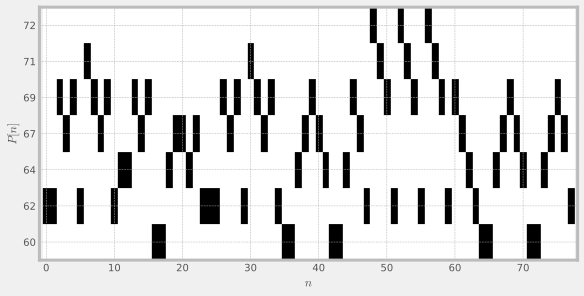

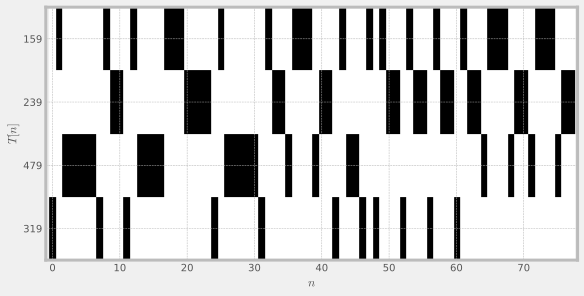

After one-hot/zero-pad


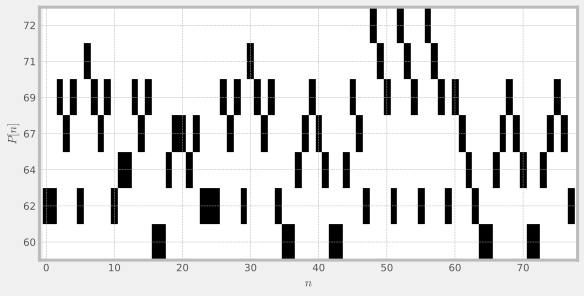

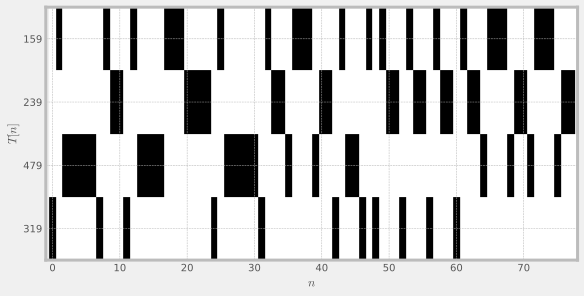

In [628]:
selected_sample=np.random.randint(0,all_pitches.shape[0])
file_label=list(dataset_token_final_ohe.keys())[selected_sample]
print("File %s"%file_label)
print("Before one-hot/zero-pad")
plotMelody(dataset_token_final_ohe[file_label]["P"],dataset_token_final_ohe[file_label]["T"],plotMelody_dict)
print("After one-hot/zero-pad")
plotMelody(all_pitches[selected_sample,:,:],all_durations[selected_sample,:,:],plotMelody_dict)

In [236]:
import pickle
mp2_data={
    "all_pitches":all_pitches,
    "all_durations":all_durations,
    "plotMelody_dict":plotMelody_dict,
}
pickle.dump(mp2_data,open("mp2_data.p","wb"))

## Exercise 5: Building and training a generative model of  note transition with the Keras functional API
### Description

The Keras Sequential model is very efficient for fast prototyping, however suffers from a lack of design liberty. The Keras Functional API is only slightly more complex but allows for more control on the different parts of your model. You will be using the Functional API for the rest of this project. Please read carefully the [documentation](https://keras.io/getting-started/sequential-model-guide/). 

Here, you will be constructing your RNN model of note transition. To achieve that, your model should be trained to approximate the probability distribution of the upcoming note (observed as two output softmax layers - one for pitch and one for duration) given the current note (given as input) and the model internal representation of the history of notes (its hidden state). To achieve that, set the Keras RNN layer argument "return_sequences" to True when building your model. Doing this will give you an output for each note, rather than a single output at the end of the sequence. During training, the target at each time step is the next note pitch and duration.

You are free to use your own architecture but make sure to use at least 128 hidden units, Masking, and dropout to prevent overfitting. Your model should have two output (softmax) layers, one related to the pitch predictions that you should name `YP`, and the other related to the duration predictions `YT`. You should monitor both the loss (categorical_crossentropy) and the accuracy. For your best model, you should reach 40%/75% accuracy on the pitch/duration predictions.

1. Train your first model composed of SimpleRNN cells for min 250 epochs and save the model/parameters that lead to the higher accuracy on the validating set. Use a validation split of 0.2. Try  If you correctly named the output layers (`YP` and `YT`) use the provided `plotLearningCurves(History)` function to plot the learning curves by giving the History object returned by the Keras fit function as argument.  
2. Train a second model where you replaced the SimpleRNN units with GRUs (LSTM unit equivalent that requires less parameters). Make sure you use the same hyperparameters as before. Plot the learning curves.
3. On a single plot, adapt the `plotLearningCurves(History)` function to compare the validation learning curves of the simpleRNN and GRU models. In other words, plot the validation loss vs epoch for pitch/duration for the simpleRNN and GRU models. Do the same for accuracies.


### Solution

In [ ]:
#Load data if needed
import pickle
mp2_data=pickle.load(open("mp2_data.p","rb"))
all_pitches=mp2_data["all_pitches"]
all_durations=mp2_data["all_durations"]
plotMelody_dict=mp2_data["plotMelody_dict"]

In [530]:
from keras.layers import SimpleRNN

def buildModel(dictionaries, batch_length, dropout=0.2, activation='GRU', Hsize=128,get_hidden_act=False):
    X = dict()
    H = dict()
    M = dict()
    Y = dict()
    
    X['T'] = Input(shape=(batch_length, len(dictionaries['T'])), name="XT")
    X['P'] = Input(shape=(batch_length, len(dictionaries['P'])), name="XP")
    
    M['T'] = Masking(mask_value=0., name="MT")(X['T'])
    M['P'] = Masking(mask_value=0., name="MP")(X['P'])
    
    H['1'] = Concatenate(name="MergeX")([M['T'], M['P']])
    if activation == 'GRU':
        inter=GRU(units=128,
                  activation='tanh',
                  use_bias=True, 
                  dropout=0.4,
                  return_sequences=True)(H['1'])
        test=GRU(units=128,
                  activation='tanh',
                  use_bias=True, 
                  dropout=0.4,
                  return_sequences=True)(inter)
        if not get_hidden_act:
            Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(test)#Input(s) to duration output layer)
            Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(test)#Input(s) to pitch output layer)
        else:
            outp=Concatenate(name="MergeFin")([inter,test])
    elif activation == 'LSTM':
        # Similar to one from https://arxiv.org/pdf/1802.05162.pdf
        inter_mt=LSTM(units=64,
                  activation='tanh',
                  use_bias=True, 
                  dropout=0.3,
                  return_sequences=True)(M['T'])
        inter_mp=LSTM(units=128,
                  activation='tanh',
                  use_bias=True, 
                  dropout=0.3,
                  return_sequences=True)(M['P'])
        H['2'] = Concatenate(name="MergeH")([inter_mt, inter_mp])
        inter_conc=LSTM(units=256,
                  activation='tanh',
                  use_bias=True, 
                  dropout=0.3,
                  return_sequences=True)(H['2'])
        pre_fint=LSTM(units=64,
                  activation='tanh',
                  use_bias=True, 
                  dropout=0.3,
                  return_sequences=True)(inter_conc)
        pre_finp=LSTM(units=128,
                  activation='tanh',
                  use_bias=True, 
                  dropout=0.3,
                  return_sequences=True)(inter_conc)
        fin_t = Concatenate(name="MergeFinT")([pre_fint, inter_mt])
        fin_p = Concatenate(name="MergeFinP")([pre_finp, inter_mp])
        if not get_hidden_act:
            Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(fin_t)#Input(s) to duration output layer)
            Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(fin_p)#Input(s) to pitch output layer)
        else:
            outp=Concatenate(name="MergeFin")([fin_t,fin_p])
    elif activation == 'RNN':
        test=SimpleRNN(units=300,
                  activation='tanh',
                  use_bias=True, 
                  dropout=0.4,
                  return_sequences=True,name="SRNN")(H['1'])
        if not get_hidden_act:
            Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(test)#Input(s) to duration output layer)
            Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(test)#Input(s) to pitch output layer)
        else:
            outp=test
    if not get_hidden_act:
        model = Model(inputs = [X['T'], X['P']], outputs = [Y['T'], Y['P']])
    else:
        model = Model(inputs = [X['T'], X['P']], outputs = outp)
    opt = Adam() 
    
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=opt,
        metrics=['acc'])
    
    return model

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from keras_tqdm import TQDMNotebookCallback
from IPython.display import clear_output

import keras
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

my_callbacks=[TQDMNotebookCallback(leave_inner=False,leave_outer=True)] #checkpoint

# RNN 
RNNmodel = buildModel(dictionaries=plotMelody_dict, 
                      batch_length=all_pitches[0,:,:].shape[0]-1,#Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      activation='RNN')

#print(RNNmodel.summary())
res_simple_rnn = RNNmodel.fit(x={'XT': all_durations[:,:-1,:],'XP': all_pitches[:,:-1,:]},
                       y={'YT': all_durations[:,1:,:], 'YP': all_pitches[:,1:,:]},
                       batch_size=32,epochs=300,verbose=0,
                       validation_split=0.2,
                       callbacks=[])
#RNNmodel.save_weights("RNN_model_weights.h5")

# GRU
GRUmodel = buildModel(dictionaries=plotMelody_dict, 
                      batch_length=all_pitches[0,:,:].shape[0]-1,#Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      activation='GRU')

#print(GRUmodel.summary())
res_simple_gru = GRUmodel.fit(x={'XT': all_durations[:,:-1,:],'XP': all_pitches[:,:-1,:]},
                       y={'YT': all_durations[:,1:,:], 'YP': all_pitches[:,1:,:]},
                       batch_size=32,epochs=300,verbose=2,
                       validation_split=0.2,
                       callbacks=[])
#GRUmodel.save_weights("GRU_model_weights.h5")

# LSTM
LSTMmodel = buildModel(dictionaries=plotMelody_dict,
                      dropout=0.3,
                      batch_length=all_pitches[0,:,:].shape[0]-1,#Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      activation='LSTM')
#print(LSTMmodel.summary())
res_simple_lstm = LSTMmodel.fit(x={'XT': all_durations[:,:-1,:], 'XP': all_pitches[:,:-1,:]},
                        y={'YT': all_durations[:,1:,:], 'YP': all_pitches[:,1:,:]},
                        batch_size=32,epochs=300,verbose=0,
                        validation_split=0.2,
                        callbacks=my_callbacks)

#LSTMmodel.save_weights("LSTM_model_weights.h5")

In [ ]:
RNNmodel.load_weights("RNN_model_weights.h5")
GRUmodel.load_weights("GRU_model_weights.h5")
LSTMmodel.load_weights("LSTM_model_weights.h5")

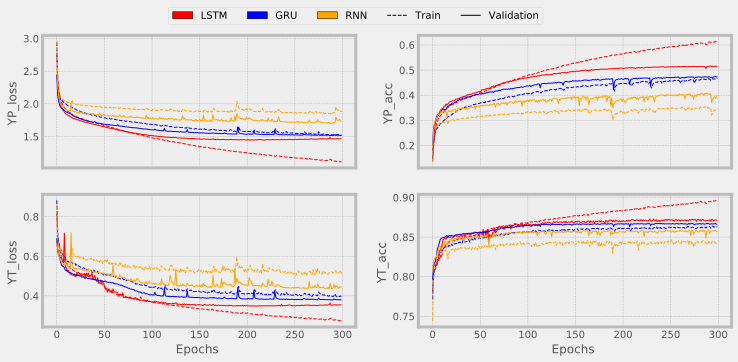

In [616]:
#Load if needed
import pickle ,matplotlib
res_simple_lstm=pickle.load(open("res_simple_lstm.p","rb")).history
res_simple_gru=pickle.load(open("res_simple_gru.p","rb")).history
res_simple_rnn=pickle.load(open("single_rep_simple_rnn.p","rb"))[0].history

plt.style.reload_library()
fig, ax = plt.subplots(nrows=2, ncols=2, sharex="col", sharey=False, figsize=(11,5))
matplotlib.rcParams['font.size'] =10
matplotlib.rcParams['font.monospace'] ="monospace"

#YP Loss
ax[0,0].plot(res_simple_lstm['YP_loss'], '--', c="red",lw=1, label='Pitch train loss')
ax[0,0].plot(res_simple_gru['YP_loss'], '--', c="blue",lw=1, label='Pitch train loss')
ax[0,0].plot(res_simple_rnn['YP_loss'], '--', c="orange",lw=1, label='Pitch train loss')
ax[0,0].plot(res_simple_lstm['val_YP_loss'], c="red",lw=1, label='Pitch val loss')
ax[0,0].plot(res_simple_gru['val_YP_loss'], c="blue",lw=1, label='Pitch val loss')
ax[0,0].plot(res_simple_rnn['val_YP_loss'], c="orange",lw=1, label='Pitch val loss')
ax[0,0].set_ylabel("YP_loss ")
ax[0,0].xaxis.set_tick_params(labelsize=10)
ax[0,0].yaxis.set_tick_params(labelsize=10)

ax[1,0].plot(res_simple_lstm['YT_loss'], '--', c="red",lw=1, label='Dur train loss')
ax[1,0].plot(res_simple_gru['YT_loss'], '--', c="blue",lw=1, label='Dur train loss')
ax[1,0].plot(res_simple_rnn['YT_loss'], '--', c="orange",lw=1, label='Dur train loss')
ax[1,0].plot(res_simple_lstm['val_YT_loss'], c="red",lw=1, label='Dur val loss')
ax[1,0].plot(res_simple_gru['val_YT_loss'], c="blue",lw=1, label='Dur val loss')
ax[1,0].plot(res_simple_rnn['val_YT_loss'], c="orange",lw=1, label='Dur val losss')
ax[1,0].set_ylabel("YT_loss ")
ax[1,0].xaxis.set_tick_params(labelsize=10)
ax[1,0].yaxis.set_tick_params(labelsize=10)
ax[1,0].set_xlabel("Epochs ")

ax[0,1].plot(res_simple_lstm['YP_acc'], '--', c="red",lw=1, label='Pitch train loss')
ax[0,1].plot(res_simple_gru['YP_acc'], '--', c="blue",lw=1, label='Pitch train loss')
ax[0,1].plot(res_simple_rnn['YP_acc'], '--', c="orange",lw=1, label='Pitch train loss')
ax[0,1].plot(res_simple_lstm['val_YP_acc'], c="red",lw=1, label='Pitch val loss')
ax[0,1].plot(res_simple_gru['val_YP_acc'], c="blue",lw=1, label='Pitch val loss')
ax[0,1].plot(res_simple_rnn['val_YP_acc'], c="orange",lw=1, label='Pitch val loss')
ax[0,1].set_ylabel("YP_acc ")
ax[0,1].xaxis.set_tick_params(labelsize=10)
ax[0,1].yaxis.set_tick_params(labelsize=10)


ax[1,1].plot(res_simple_lstm['YT_acc'], '--', c="red",lw=1, label='lstm')
ax[1,1].plot(res_simple_gru['YT_acc'], '--', c="blue",lw=1, label='gru ')
ax[1,1].plot(res_simple_rnn['YT_acc'], '--', c="orange",lw=1, label='rnn')
ax[1,1].plot(res_simple_lstm['val_YT_acc'], c="red",lw=1, label='val loss')
ax[1,1].plot(res_simple_gru['val_YT_acc'], c="blue", lw=1,label='Dur val loss')
ax[1,1].plot(res_simple_rnn['val_YT_acc'], c="orange",lw=1, label='Dur val losss')
ax[1,1].set_ylabel("YT_acc ")
ax[1,1].set_xlabel("Epochs ")
ax[1,1].xaxis.set_tick_params(labelsize=10)
ax[1,1].yaxis.set_tick_params(labelsize=10)

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
custom_patches = [mpatches.Patch(color="red", ec='k'),
                mpatches.Patch(color="blue", ec='k'),
                mpatches.Patch(color="orange", ec='k')]
custom_lines = [Line2D([0], [0], color="k", lw=1,ls='--'),
                Line2D([0], [0], color="k", lw=1)]

ax[0,0].legend(custom_patches+custom_lines, ['LSTM', 'GRU', 'RNN',"Train","Validation"],
          loc='upper center', bbox_to_anchor=(1, 1.25),
          ncol=5, fancybox=True, shadow=False)

plt.show()

**Question**: What are the best prediction accuracies you obtained? With which model?
    
**Answer**: The best prediction are obtained when using the LSTM model, achieving a validation accuracy of respectively 51% and 87% for the sequence of durations and pitches. It shoudl also be noted that after Epoch 100 this model starts slightly overfitting the training data so potential improvements on this model's architecture should use higher values for the dropout rates between layers. The GRU model achives a close performance for the durations sequence while lagging behind in terms of accuracy when predicting the sequence of pitches. 

**Question**: In a few sentences, comment on the plot comparing learning curves for the two activation function.
    
**Answer**: During the initial phase of the learning, the two model differ slightly in behavior: the GRU model seems to take longer to become as accurate as the RNN model with respect to the training data. This is however not true,for the models' performance with respect to the validation data where both seem to be equivalent in terms of accuracies and losses. After this initial phase the GRU model seems to learn a more powerful hidden representation than the RNN especially with respect to the pitches sequences where the accuracy gain whn using GRU instead of RNN seems to be around 10 %. This can be understood by the additional degrees of freedom the model has with respect to the RNN since it contains almost twice the number of parameters of the RNN model. We should finally note that the leanring curves for the RNN seem to be noisier than the ones observed when training the GRU model which might be due to the vanishing gradient problem intrinsic to RNNs.

## Exercise 6: Visualizing the model
### Description

1. Using the model.predict and plotMelody functions, show the outputs of your best model when fed with 4 randomly selected melodies. Report the prediction accuracies as well.
2. For the same melodies, plot the hidden state evolution accross time steps. Construct a 2 dimensional matrix with the first dimension being time and the second the concatenation of all hidden unit activations and plot it using the provided `plotMelody` function. To get the hidden states of your network, you can modify the `buildModel` function so that you have another computation graph (another model with the same layers, but the output layer) returning you the hidden states. However, other approaches are equally valid.  
3. For each hidden unit $i$ and accross the entire dataset, compute the average absolute change in activation $\Delta A_i$. Be careful not to take masked timesteps into account. Plot the histogram (50 bins) of this average for the RNN and GRU models on the same figure.

### Solution

#### Plotting Helper

In [737]:
def myplotMelody(P_arr, T_arr, dictionaries, PrP_arr, PrT_arr,H_arr,melodies,title):
    if bool(np.any(H_arr[0])):
        fig,ax=plt.subplots(nrows=3,ncols=len(P_arr),figsize=(11,6))
        for it,P,T,PrP,PrT,H in (zip(range(len(P_arr)),P_arr,T_arr,PrP_arr,PrT_arr,H_arr)):
            P = np.asarray(P)
            T = np.asarray(T)
            if len(P.shape) == 1:#if array
                P = np_utils.to_categorical(P, len(dictionaries['P']))
            if len(T.shape) == 1:#if array
                T = np_utils.to_categorical(T, len(dictionaries['T']))
            xlim = [-1,np.where(P==1)[0][-1]+1]
            activeidxes = np.where(np.sum(P, axis=0)>0.)[0]
            if PrP is not None:
                targets = np.where(P[:,activeidxes]==1)
                ax[0,it].imshow(PrP[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
                ax[0,it].scatter(targets[0]-1,targets[1], color='red',s=10, marker='.') 
            else:
                ax[0,it].imshow(P[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
            ax[0,it].set_ylim([-0.5,len(activeidxes)-0.5])
            ax[0,it].set_yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
            if it==0:
                ax[0,it].set_ylabel("$P[n]$")
            ax[0,it].set_xlim(xlim)    
            ax[0,it].set_title(melodies[it],fontdict={'fontsize':10})
            activeidxes = np.where(np.sum(T, axis=0)>0.)[0]
            if PrT is not None:
                targets = np.where(T[:,activeidxes]==1)
                ax[1,it].imshow(PrT[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
                ax[1,it].scatter(targets[0]-1,targets[1], color='red',s=10, marker='.')
            else:
                ax[1,it].imshow(T[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
            ax[1,it].set_ylim([-0.5,len(activeidxes)-0.5])
            ax[1,it].set_yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
            if it==0:
                ax[1,it].set_ylabel("$T[n]$")
            ax[1,it].set_xlim(xlim)
            if H is not None:
                diff = np.mean([[abs(j-i) for i,j in zip(H[:xlim[1]-1,k], H[1:xlim[1],k])] for k in range(H.shape[1])], axis=1)
                sortidx = np.argsort(-diff)
                H = H[:,sortidx]
                ax[2,it].imshow(H.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
                ax[2,it].set_xlim([-1,np.where(T==1)[0][-1]+1])
                if it==0:
                    ax[2,it].set_ylabel("$H[n]$")
                ax[2,it].set_xlabel("$n$")
    else:
        fig,ax=plt.subplots(nrows=2,ncols=len(P_arr),figsize=(11,4))
        for it,P,T,PrP,PrT,H in (zip(range(len(P_arr)),P_arr,T_arr,PrP_arr,PrT_arr,H_arr)):
            P = np.asarray(P)
            T = np.asarray(T)
            if len(P.shape) == 1:#if array
                P = np_utils.to_categorical(P, len(dictionaries['P']))
            if len(T.shape) == 1:#if array
                T = np_utils.to_categorical(T, len(dictionaries['T']))
            xlim = [-1,np.where(P==1)[0][-1]+1]
            activeidxes = np.where(np.sum(P, axis=0)>0.)[0]
            if PrP is not None:
                targets = np.where(P[:,activeidxes]==1)
                ax[0,it].imshow(PrP[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
                ax[0,it].scatter(targets[0]-1,targets[1], color='red',s=10, marker='.') 
            else:
                ax[0,it].imshow(P[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
            ax[0,it].set_ylim([-0.5,len(activeidxes)-0.5])
            ax[0,it].set_yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
            if it==0:
                ax[0,it].set_ylabel("$P[n]$")
            ax[0,it].set_xlim(xlim)   
            ax[0,it].set_title(melodies[it],fontdict={'fontsize':10})
            activeidxes = np.where(np.sum(T, axis=0)>0.)[0]
            if PrT is not None:
                targets = np.where(T[:,activeidxes]==1)
                ax[1,it].imshow(PrT[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
                ax[1,it].scatter(targets[0]-1,targets[1], color='red',s=10, marker='.')
            else:
                ax[1,it].imshow(T[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
            ax[1,it].set_ylim([-0.5,len(activeidxes)-0.5])
            ax[1,it].set_yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
            ax[1,it].set_xlabel("$n$")
            if it==0:
                ax[1,it].set_ylabel("$T[n]$")
            ax[1,it].set_xlim(xlim)
    plt.suptitle(title)
    plt.show()

#### Output Visualization

In [691]:
rd_melodies=np.random.randint(low=0,high=all_pitches.shape[0],size=4)
eval_res_rnn=RNNmodel.evaluate(x={'XT': all_durations[rd_melodies,:-1,:],'XP': all_pitches[rd_melodies,:-1,:]},
                      y={'YT': all_durations[rd_melodies,1:,:], 'YP': all_pitches[rd_melodies,1:,:]},
                    )
metrics_outp_rnn=RNNmodel.metrics_names
print("RNN: ",list(zip(metrics_outp_rnn,["%.3f"%x for x in eval_res_rnn])))

eval_res_gru=GRUmodel.evaluate(x={'XT': all_durations[rd_melodies,:-1,:],'XP': all_pitches[rd_melodies,:-1,:]},
                      y={'YT': all_durations[rd_melodies,1:,:], 'YP': all_pitches[rd_melodies,1:,:]},
                    )
metrics_outp_gru=GRUmodel.metrics_names
print("GRU: ",list(zip(metrics_outp_gru,["%.3f"%x for x in eval_res_gru])))

4/4 [==============================] - 0s 39ms/step
RNN:  [('loss', '2.365'), ('YT_loss', '0.500'), ('YP_loss', '1.865'), ('YT_acc', '0.887'), ('YP_acc', '0.332')]
4/4 [==============================] - 1s 128ms/step
GRU:  [('loss', '1.772'), ('YT_loss', '0.333'), ('YP_loss', '1.439'), ('YT_acc', '0.885'), ('YP_acc', '0.469')]


In [692]:
model_pred_rnn=RNNmodel.predict(x={'XT': all_durations[rd_melodies,:-1,:],'XP': all_pitches[rd_melodies,:-1,:]})
model_pred_gru=GRUmodel.predict(x={'XT': all_durations[rd_melodies,:-1,:],'XP': all_pitches[rd_melodies,:-1,:]})

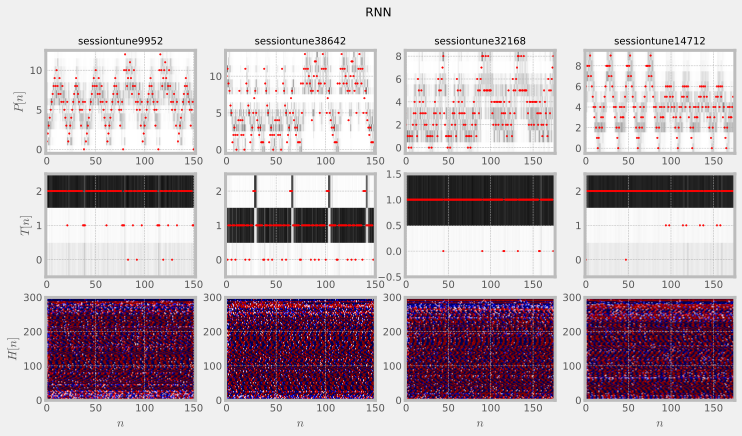

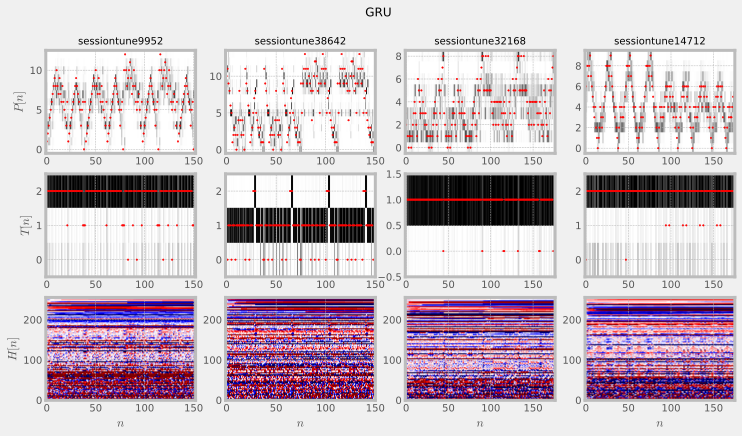

In [738]:
RNNmodel_fake = buildModel(dictionaries=plotMelody_dict, 
                      batch_length=all_pitches[0,:,:].shape[0]-1,
                      activation='RNN',get_hidden_act=True)

RNNmodel_fake.layers[-1].set_weights(RNNmodel.layers[-3].get_weights())
hidden_act_rnn=RNNmodel_fake.predict(x={'XT': all_durations[rd_melodies,:-1,:],'XP': all_pitches[rd_melodies,:-1,:]})

myplotMelody(P_arr=all_pitches[rd_melodies,:-1,:].tolist(),
             T_arr=all_durations[rd_melodies,:-1,:].tolist(),
             PrP_arr=[model_pred_rnn[1][i,:,:] for i in range(len(rd_melodies))],
             PrT_arr=[model_pred_rnn[0][i,:,:] for i in range(len(rd_melodies))],
             title="RNN",
             H_arr=[hidden_act_rnn[i,:,:] for i in range(len(rd_melodies))],
             dictionaries=plotMelody_dict,melodies=[mels[i] for i in rd_melodies])

GRUmodel_fake = buildModel(dictionaries=plotMelody_dict, 
                      batch_length=all_pitches[0,:,:].shape[0]-1,#Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      activation='GRU',get_hidden_act=True)

GRUmodel_fake.layers[-2].set_weights(GRUmodel.layers[-3].get_weights())
GRUmodel_fake.layers[-3].set_weights(GRUmodel.layers[-4].get_weights())

hidden_act_gru=GRUmodel_fake.predict(x={'XT': all_durations[rd_melodies,:-1,:],'XP': all_pitches[rd_melodies,:-1,:]})
myplotMelody(P_arr=all_pitches[rd_melodies,:-1,:].tolist(),
             T_arr=all_durations[rd_melodies,:-1,:].tolist(),
             PrP_arr=[model_pred_gru[1][i,:,:] for i in range(len(rd_melodies))],
             PrT_arr=[model_pred_gru[0][i,:,:] for i in range(len(rd_melodies))],
             title="GRU",
             H_arr=[hidden_act_gru[i,:,:] for i in range(len(rd_melodies))],
             dictionaries=plotMelody_dict,melodies=[mels[i] for i in rd_melodies])

In [625]:
# RNN Model
hidden_act_full=RNNmodel_fake.predict(x={'XT': all_durations[:,:-1,:],
                                    'XP': all_pitches[:,:-1,:]})
mean_act_change=[]
nb_melodies=all_pitches.shape[0]
nb_hidden_units=hidden_act_full.shape[-1]

for indx_melody in range(all_pitches.shape[0]):
    melody_pitch=all_pitches[indx_melody,:-1,:]
    melody_start_of_mask = [-1,np.where(melody_pitch==1)[0][-1]+1]
    melody_hidden_act=hidden_act_full[indx_melody,:,:]
    mean_abs_dif_act = np.mean([[abs(j-i) 
                                 for i,j in zip(melody_hidden_act[:melody_start_of_mask[1]-1,k],
                                    melody_hidden_act[1:melody_start_of_mask[1],k])]
                                for k in range(melody_hidden_act.shape[1])], axis=1)
    mean_act_change.append(mean_abs_dif_act)

mean_act_change=np.array(mean_act_change).reshape((nb_melodies,nb_hidden_units))
final_act_change=np.mean(mean_act_change,axis=0)

# GRU Model
hidden_act_full_gru=GRUmodel_fake.predict(x={'XT': all_durations[:,:-1,:],
                                    'XP': all_pitches[:,:-1,:]})
mean_act_change_gru=[]
nb_melodies=all_pitches.shape[0]
nb_hidden_units_gru=hidden_act_full_gru.shape[-1]

for indx_melody in range(all_pitches.shape[0]):
    melody_pitch=all_pitches[indx_melody,:-1,:]
    melody_start_of_mask = [-1,np.where(melody_pitch==1)[0][-1]+1]
    melody_hidden_act_gru=hidden_act_full_gru[indx_melody,:,:]
    mean_abs_dif_act_gru = np.mean([[abs(j-i) 
                                 for i,j in zip(melody_hidden_act_gru[:melody_start_of_mask[1]-1,k],
                                    melody_hidden_act_gru[1:melody_start_of_mask[1],k])]
                                for k in range(melody_hidden_act_gru.shape[1])], axis=1)
    mean_act_change_gru.append(mean_abs_dif_act_gru)

mean_act_change_gru=np.array(mean_act_change_gru).reshape((nb_melodies,nb_hidden_units_gru))
final_act_change_gru=np.mean(mean_act_change_gru,axis=0)

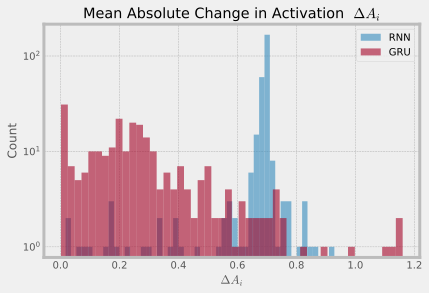

In [750]:
plt.figure(figsize=(6,4))
plt.hist(final_act_change,bins=50,alpha=0.6,normed=False,label="RNN",log=True);
plt.hist(final_act_change_gru,bins=50,alpha=0.6,normed=False,label="GRU",log=True);
plt.xlabel(r"$\Delta A_i$")
plt.ylabel("Count")
plt.title(r"Mean Absolute Change in Activation  $\Delta A_i$")
plt.legend()
plt.show()


**Question**: How does the hidden state dynamics explain the performance of the RNN vs GRU models? Explain in term of temporal dependencies and base your explanation on figures obtained in 6.2 and 6.3.
    
**Answer**: 

Let us first understand what figures 6.2 and 6.3 are describing. In the former, a continuous segment for a fixed $H(n)$ and varying $n$ describes the values output by a single unit at the output layer when time increases. Red and blue values/pixels respectively correspond to positively/negative saturated neurons ($tanh(x)=1$/$tanh(x)=-1$) at a given timestep $n$ with intermediate values in between. Just from this description we can already observe that in the RNN model, each neuron is saturated most of the time wich is not the case for the GRU model where white pixels are overall more frequent.

We can also observe that, for the RNN, horizontal segments of identically valued activations are in general shorter than in the GRU case where these segments can span the whole time interval. This can be seen as the neurons changing quicker in the RNN case than in the GRU, which is actually backed by the histogram in Figure 6.3. In this figure we see that the distribution of mean absolute activation change is biased towards 0 in the GRU model while the same distribution seems normally distributed around a value of 0.7. All things considered,  we can conclude that GRU are slower in state changes than standard 'vanilla' RNN. 

The reason behind this observed difference is actually explained in detail by  [Cho et al.](https://arxiv.org/abs/1412.3555). While traditional recurrent units always replace the activation with a new value computed from the current input and the previous hidden state, GRU units keep the existing content and add the new content on too of it. By doing so,  each unit remembers easily the existence of a specific feature in the input stream for a long series of steps (long temporal dependencies). Any important feature decided by the update gate of the GRU will no tbe overwritten and mantained as it is , slowing down potential changes in activations as the model goes through the input.


 


## Exercise 7: Generation of new melodies
### Description

1. Use your trained best model to generate new melodies. You can do that by starting with a random note, feeding it to your network and sample the output predictions in order to select the next note. Then add this note to your iteratively growing melodies. For your convenience, we provided the `sample` and `writeMIDI` functions. You can use the first in order to perform temperature sampling. The `writeMIDI` function allows you to write a MIDI file from the integer representation.
2. Try different sampling temperatures (e.g. 0.5, 1., 1.5) and observe the effect on your generated melodies.
3. Generate 32 melodies with both the RNN and GRU models
4. Listen to 4 randomly chosen melodies (2 from the GRU model and 2 from the RNN model). To play in a notebook, use a similar approach as the one shown below assuming you have the files `GRU_1.mid` and `RNN_1.mid` at the same level as this notebook. For your own curiosity, you can also directly listen to the MIDI files with your favorite MIDI player but make sure that we can listen to the 4 extracts directly from this notebook (without rerunning it). You might have to use the "Trust notebook" button (in the top right corner) to see the players. This currently only works in jupyter notebook (not jupyter lab). If you have trouble achieving that, upload the MIDI files with your submission.
5. (Optional) If you have a big enough computing power, try adding multiple and bigger layers. You could also try to improve your model with different add-ons, e.g. make your model learn when a melody ends, extend it to other datasets, ...
6. (Optional) If you are happy with your results submit a 1 hour long generated MIDI file to the [AI-generated music challenge](https://www.crowdai.org/challenges/ai-generated-music-challenge). 

### Solution

In [764]:
# Generate song
nb_melodies=all_pitches.shape[0]
nb_timesteps=all_pitches.shape[1]
nb_pitches=all_pitches.shape[-1]
nb_durations=all_durations.shape[-1]

def generate_song(model,nb_timesteps,nb_melodies,pred_time_steps,
                  T_sample,idx_pitch_melody=None,idx_duration_melody=None):
    pitchs=np.zeros((1,nb_timesteps-1,nb_pitches))
    durs=np.zeros((1,nb_timesteps-1,nb_durations))
    if idx_pitch_melody is None:
        idx_pitch_melody,idx_duration_melody=np.random.randint(0,nb_melodies,2)
    new_pitch,new_duration=(all_pitches[idx_pitch_melody,0,:].reshape((1,1,-1)),
                                      all_durations[idx_duration_melody,0,:].reshape((1,1,-1)))
    pitchs[0,0,:],durs[0,0,:]=new_pitch,new_duration    
    for ts in range(pred_time_steps):
        pred=model.predict(x={'XT': durs,'XP': pitchs})
        pred_dur,pred_pitch=(sample(pred[0][0,ts,:],temperature=T_sample),
                             sample(pred[1][0,ts,:],temperature=T_sample))
        new_pitch,new_duration=np.eye(nb_pitches)[pred_pitch],np.eye(nb_durations)[pred_dur]
        pitchs[0,ts+1,:],durs[0,ts+1,:]=new_pitch,new_duration    
    return (np.array(pitchs).reshape((1,nb_timesteps-1,nb_pitches)),
            np.array(durs).reshape((1,nb_timesteps-1,nb_durations)),
           idx_pitch_melody,idx_duration_melody)

### Temperature Effect

In [765]:
print('RNN_t_0_5')
rnn_melody_pitches,rnn_melody_durs,ix_mel,ix_dur=generate_song(RNNmodel,nb_timesteps,nb_melodies,
                                                               pred_time_steps=200,T_sample=0.5)
xP_writeMIDI=np.where(rnn_melody_pitches[0,:,:]==1)[-1]
xT_writeMIDI=np.where(rnn_melody_durs[0,:,:]==1)[-1]
writeMIDI(xP_writeMIDI, xT_writeMIDI, plotMelody_dict, "RNN_1T0_5.mid")
music21.midi.translate.midiFilePathToStream('RNN_1T0_5.mid').show('midi')

print('RNN_t_1')
rnn_melody_pitches,rnn_melody_durs,_,_=generate_song(RNNmodel,nb_timesteps,nb_melodies,
                                                               pred_time_steps=200,T_sample=1,
                                                              idx_pitch_melody=ix_mel,
                                                              idx_duration_melody=ix_dur)
xP_writeMIDI=np.where(rnn_melody_pitches[0,:,:]==1)[-1]
xT_writeMIDI=np.where(rnn_melody_durs[0,:,:]==1)[-1]
writeMIDI(xP_writeMIDI, xT_writeMIDI, plotMelody_dict, "RNN_1T1.mid")
music21.midi.translate.midiFilePathToStream('RNN_1T1.mid').show('midi')

print('RNN_t_1_5')
rnn_melody_pitches,rnn_melody_durs,_,_=generate_song(RNNmodel,nb_timesteps,nb_melodies,
                                                               pred_time_steps=200,T_sample=1.5,
                                                              idx_pitch_melody=ix_mel,
                                                              idx_duration_melody=ix_dur)
xP_writeMIDI=np.where(rnn_melody_pitches[0,:,:]==1)[-1]
xT_writeMIDI=np.where(rnn_melody_durs[0,:,:]==1)[-1]
writeMIDI(xP_writeMIDI, xT_writeMIDI, plotMelody_dict, "RNN_1T1_5.mid")
music21.midi.translate.midiFilePathToStream('RNN_1T1_5.mid').show('midi')

Automatic pdb calling has been turned ON
RNN_t_0_5


RNN_t_1


RNN_t_1_5


### Music generation

In [771]:
#rnn
print('Generate RNN')
for i_rnn in range(32):
    test_melody_pitches,test_melody_durs,_,_=generate_song(RNNmodel,nb_timesteps,nb_melodies,pred_time_steps=200,T_sample=1.1)
    xP_writeMIDI=np.where(test_melody_pitches[0,:,:]==1)[-1]
    xT_writeMIDI=np.where(test_melody_durs[0,:,:]==1)[-1]
    writeMIDI(xP_writeMIDI, xT_writeMIDI, plotMelody_dict, "RNN_%d.mid"%i_rnn)

Generate RNN


In [772]:
print('Generate GRU')
for i_gru in range(32):
    test_melody_pitches_gru,test_melody_durs_gru,_,_=generate_song(GRUmodel,nb_timesteps,nb_melodies,pred_time_steps=200,T_sample=1.1)
    xP_writeMIDI_gru=np.where(test_melody_pitches_gru[0,:,:]==1)[-1]
    xT_writeMIDI_gru=np.where(test_melody_durs_gru[0,:,:]==1)[-1]
    writeMIDI(xP_writeMIDI_gru, xT_writeMIDI_gru, plotMelody_dict, "GRU_%d.mid"%i_gru)

Generate GRU


In [773]:
ix_rnn=np.random.randint(0,32,2)
ix_gru=np.random.randint(0,32,2)
print("RNN 1")
music21.midi.translate.midiFilePathToStream('RNN_%d.mid'%ix_rnn[0]).show('midi')
print("RNN 2")
music21.midi.translate.midiFilePathToStream('RNN_%d.mid'%ix_rnn[1]).show('midi')
print("GRU 1")
music21.midi.translate.midiFilePathToStream('GRU_%d.mid'%ix_gru[0]).show('midi')
print("GRU 2")
music21.midi.translate.midiFilePathToStream('GRU_%d.mid'%ix_gru[1]).show('midi')

RNN 1


RNN 2


GRU 1


GRU 2


**Question**: What is the effect of the sampling temperature on the generated melodies?
    
**Answer**: The sampling is done by mapping each output probability $q_i$ to a new probability $p_i=\text{softmax}(\text{exp}(\frac{\text{ln}(q_i)}{T}))$ and then sampling ftom the newly defined multinomial distribution. By decreasing  the temperature we are actually increasing the original probabilities enhancing the possibility that the model selects the likeliest pitch and duration as the next note. It's at this temperature regime that the model will tend to generate melodies that are the closest to the ones observed in the training dataset. On the other hand, increasing the temperature tends to give a flatter probability distribution increasing the probability of selecting an unlikely pitch/duration as the next node and hence diverging the most from what the model learned from the training melodies.

**Question**: Are the generated melodies from the RNN model different from the one generated by the GRU model? If yes, what are the main differences?

**Answer**: 
It would seem that the period of the rythms seem to be longer for the GRU than the RNNs where rythms don't generally last too long. This gives the RNN melodies an easy to track continuity that might be caused by the inability of the 
underlying model of depending on past distant melodies due to the vanshing gradient problem.